In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

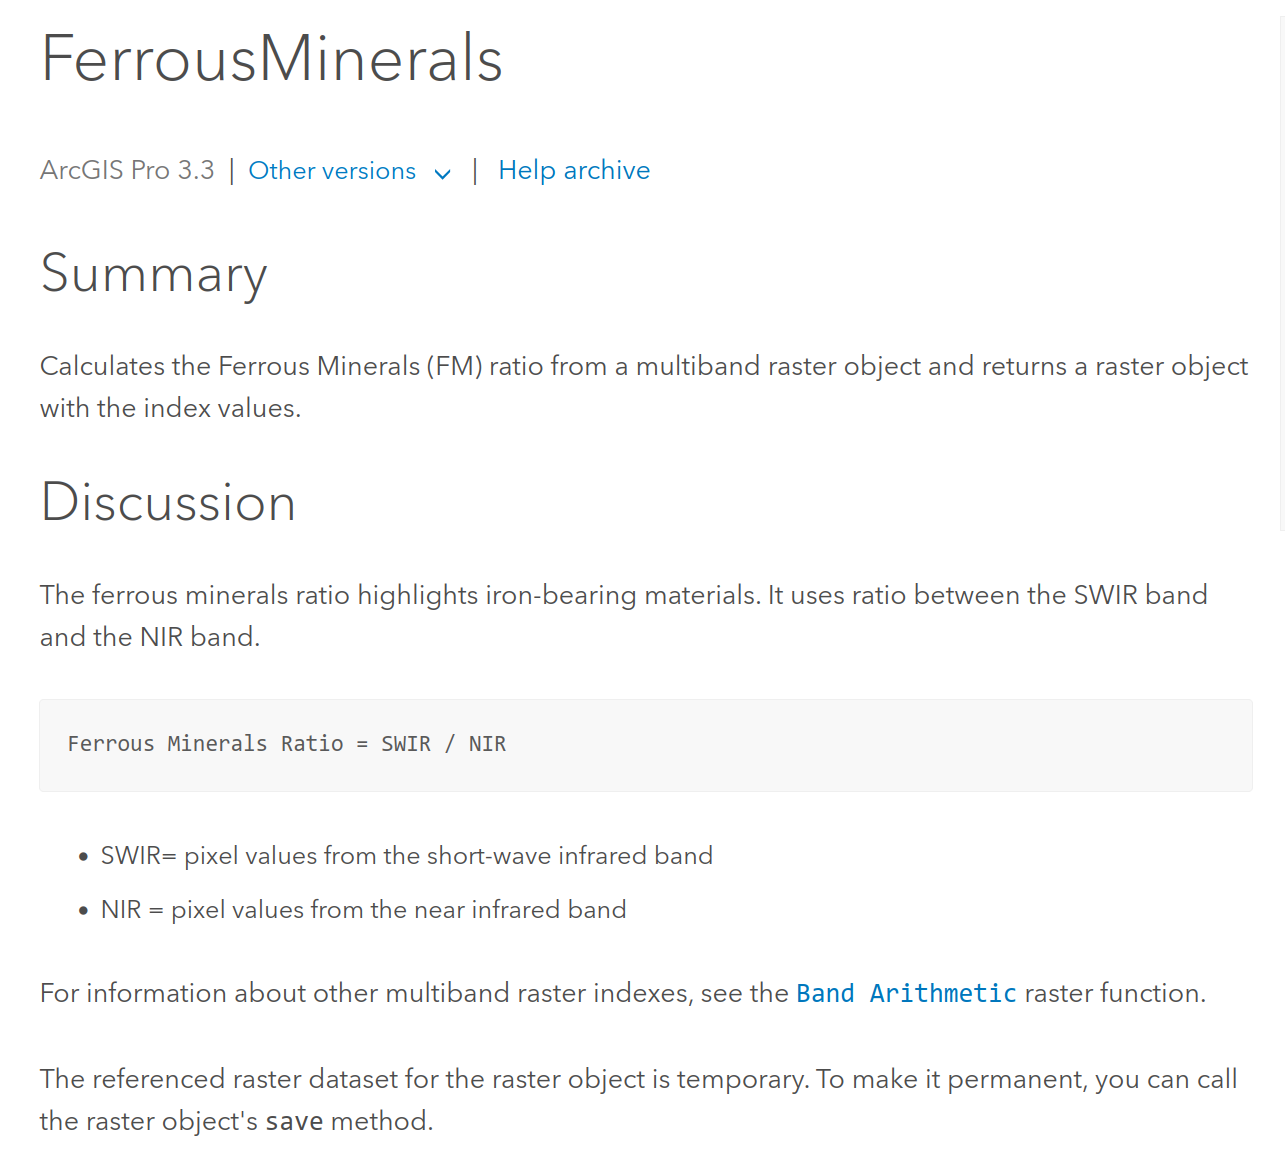

In [6]:
PATH = "/home/manuel/Imágenes/"
Image(filename = PATH + "fmr.png")

In [4]:
%pip install -q geopandas

Note: you may need to restart the kernel to use updated packages.


Paso 1: Leer los paths de las bandas SWIR y NIR

In [5]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

#nir_path = "/media/manuel/BE8A98BF8A98759D/Minera_LasCenizas/2018/01/S2B_MSIL2A_20180119T143749_N0500_R096_T19HCE_20230803T004501.SAFE/GRANULE/L2A_T19HCE_A004555_20180119T144815/IMG_DATA/R10m/T19HCE_20180119T143749_B08_10m.jp2"
nir_path = "/media/manuel/BE8A98BF8A98759D/Minera_LasCenizas/2024/07/S2B_MSIL2A_20240706T143749_N0510_R096_T19HBE_20240706T183738.SAFE/GRANULE/L2A_T19HBE_A038303_20240706T144712/IMG_DATA/R10m/T19HBE_20240706T143749_B08_10m.jp2"
#swir_path = "/media/manuel/BE8A98BF8A98759D/Minera_LasCenizas/2018/01/S2B_MSIL2A_20180119T143749_N0500_R096_T19HCE_20230803T004501.SAFE/GRANULE/L2A_T19HCE_A004555_20180119T144815/IMG_DATA/R20m/T19HCE_20180119T143749_B11_20m.jp2"
swir_path = "/media/manuel/BE8A98BF8A98759D/Minera_LasCenizas/2024/07/S2B_MSIL2A_20240706T143749_N0510_R096_T19HBE_20240706T183738.SAFE/GRANULE/L2A_T19HBE_A038303_20240706T144712/IMG_DATA/R20m/T19HBE_20240706T143749_B11_20m.jp2"

Paso 2: Transformación para que ambas bandas tengan la resolución correcta

In [6]:
def remuestrear_imagen(path, escala):
    with rasterio.open(path) as src:
        # Calcular nuevas dimensiones
        nueva_altura = int(src.height * escala)
        nueva_anchura = int(src.width * escala)
        
        # Remuestreo
        data = src.read(
            out_shape=(src.count, nueva_altura, nueva_anchura),
            resampling=Resampling.bilinear
        )
        
        # Calcular nueva transformación
        nueva_transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]),
            (src.height / data.shape[-2])
        )
        
        return data, nueva_transform

# Remuestrear NIR de 10m a 20m para que coincida con SWIR
nir_data, nir_transform = remuestrear_imagen(nir_path, 0.5)

# Leer SWIR sin remuestrear (ya está a 20m)
with rasterio.open(swir_path) as src:
    swir_data = src.read(1)  # Lee la primera banda del archivo (y única en este caso)


Paso 3: Calcular el FMR y plotear

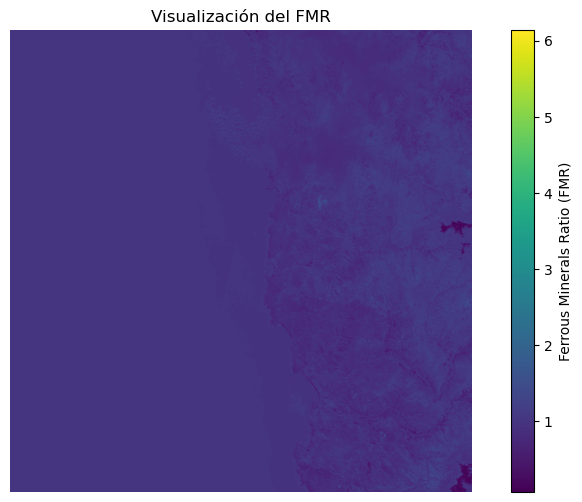

In [7]:
# Convertir datos a float para evitar problemas con la división de enteros
nir_data = nir_data[0].astype('float32')  # Asegurarse de que sea 2D
swir_data = swir_data.astype('float32')

# Evitar divisiones por cero
nir_data[nir_data == 0] = np.nan

# Calcular FMR
fmr = swir_data / nir_data

# Manejar valores NaN o infinitos resultantes de la división por cero o por datos no válidos
fmr = np.nan_to_num(fmr, nan=0.0, posinf=0.0, neginf=0.0)

# Visualizar FMR
plt.figure(figsize=(10, 6))
plt.imshow(fmr, cmap='viridis')
plt.colorbar(label='Ferrous Minerals Ratio (FMR)')
plt.title('Visualización del FMR')
plt.axis('off')  # Omitir los ejes para una vista limpia
plt.show()


Paso 4: Verificar y transformar el CRS del polígono

In [8]:
# Cargar el archivo GeoJSON que contiene el polígono
poligono = gpd.read_file('minera_lascenizas.geojson')

# Verificar y transformar el CRS del polígono para que coincida con el raster
with rasterio.open(nir_path) as src:
    raster_crs = src.crs

# Transformar el CRS del polígono si es necesario
if poligono.crs != raster_crs:
    poligono = poligono.to_crs(raster_crs)


Paso 5: Recortar el FMR según el polígono importado

In [9]:
from rasterio.mask import mask

def recortar_imagen_con_poligono(imagen, poligono):
    with rasterio.open(imagen) as src:
        out_image, out_transform = mask(src, poligono.geometry, crop=True)
        out_meta = src.meta.copy()

        # Actualizar los metadatos para coincidir con las dimensiones del recorte
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    return out_image, out_meta

# Guardar FMR como un archivo temporal para poder recortarlo
fmr_temp_path = 'fmr_temp.tif'
with rasterio.open(fmr_temp_path, 'w', driver='GTiff', height=fmr.shape[0],
                   width=fmr.shape[1], count=1, dtype=fmr.dtype, transform=nir_transform) as dst:
    dst.write(fmr, 1)

# Recortar FMR con el polígono
fmr_recortada, fmr_meta = recortar_imagen_con_poligono(fmr_temp_path, poligono)


Paso 5: Recortar el FMR según el polígono importado

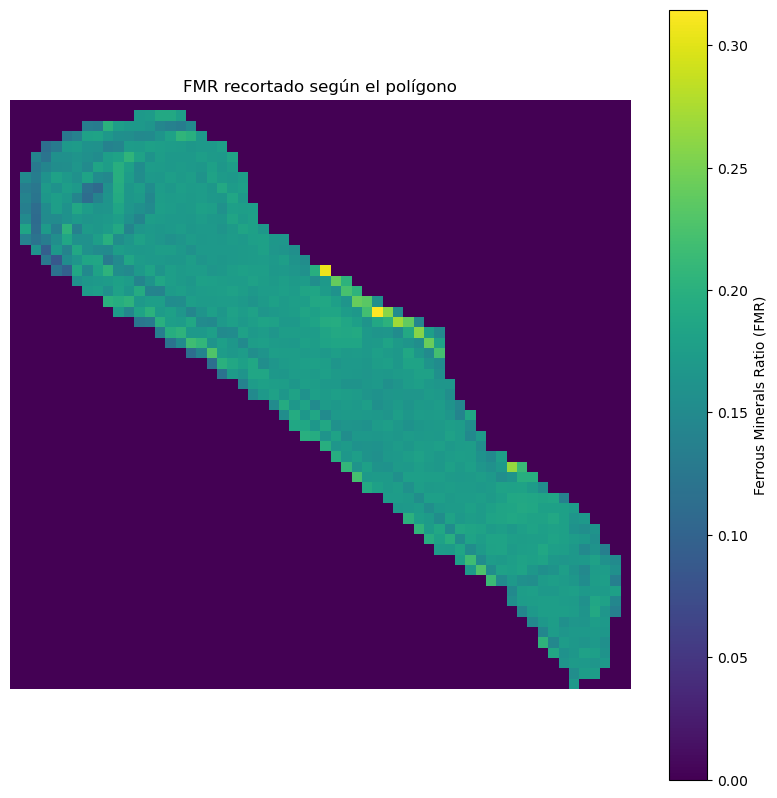

In [23]:
# Visualizar FMR recortado
plt.figure(figsize=(10, 10))
plt.imshow(np.squeeze(fmr_recortada), cmap='viridis')
plt.colorbar(label='Ferrous Minerals Ratio (FMR)')
plt.title('FMR recortado según el polígono')
plt.axis('off')  # Omitir los ejes para una vista limpia
plt.show()


In [11]:
fmr_recortada

array([[[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 1.1048781, 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]]], dtype=float32)

<AxesSubplot:>

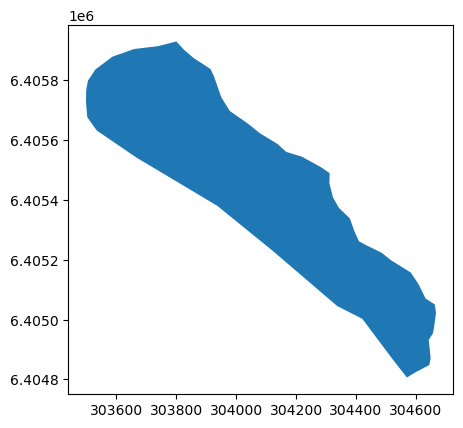

In [12]:
poligono.plot()


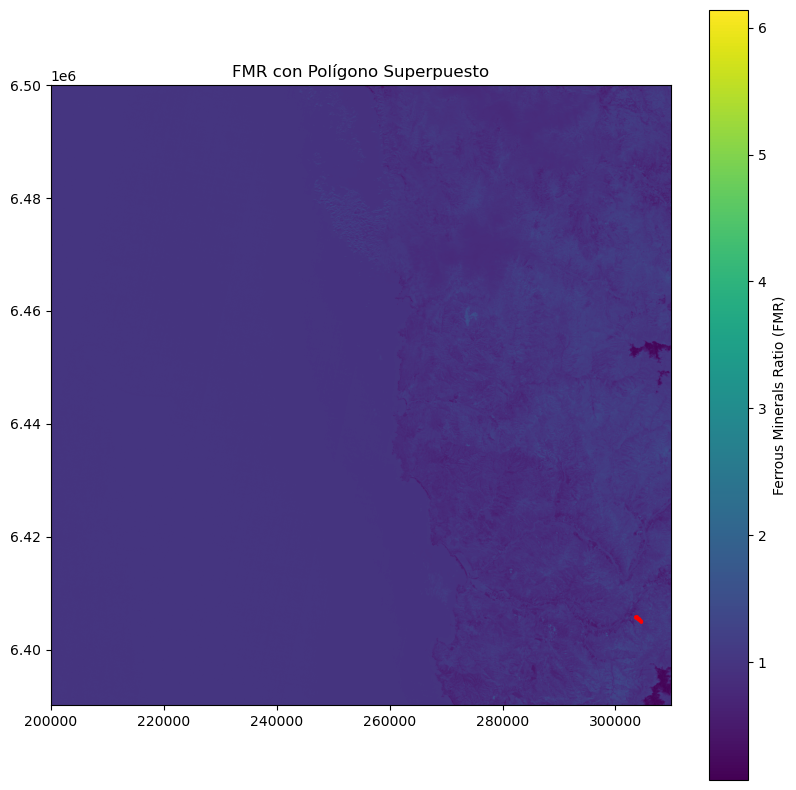

In [13]:
# Obtener las coordenadas de los límites del raster
with rasterio.open(nir_path) as src:
    bounds = src.bounds

# Visualizar FMR con el polígono superpuesto
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar FMR
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
ax.imshow(fmr, cmap='viridis', extent=extent)

# Añadir el polígono
poligono.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

# Añadir etiquetas y título
plt.colorbar(ax.imshow(fmr, cmap='viridis', extent=extent), ax=ax, label='Ferrous Minerals Ratio (FMR)')
ax.set_title('FMR con Polígono Superpuesto')
plt.show()


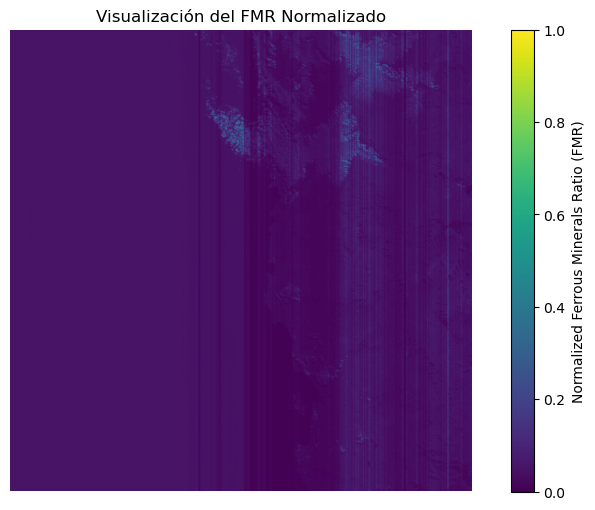

In [14]:
# Convertir datos a float para evitar problemas con la división de enteros
nir_data = nir_data[0].astype('float32')  # Asegurarse de que sea 2D
swir_data = swir_data.astype('float32')

# Evitar divisiones por cero
nir_data[nir_data == 0] = np.nan

# Calcular FMR
fmr = swir_data / nir_data

# Manejar valores NaN o infinitos resultantes de la división por cero o por datos no válidos
fmr = np.nan_to_num(fmr, nan=0.0, posinf=0.0, neginf=0.0)

# Normalizar FMR usando Min-Max Scaling
fmr_min = np.min(fmr)
fmr_max = np.max(fmr)
fmr_normalized = (fmr - fmr_min) / (fmr_max - fmr_min)

# Visualizar FMR normalizado
plt.figure(figsize=(10, 6))
plt.imshow(fmr_normalized, cmap='viridis')
plt.colorbar(label='Normalized Ferrous Minerals Ratio (FMR)')
plt.title('Visualización del FMR Normalizado')
plt.axis('off')  # Omitir los ejes para una vista limpia
plt.show()


In [15]:

# Verificar y transformar el CRS del polígono para que coincida con el raster
with rasterio.open(nir_path) as src:
    raster_crs = src.crs

# Transformar el CRS del polígono si es necesario
if poligono.crs != raster_crs:
    poligono = poligono.to_crs(raster_crs)


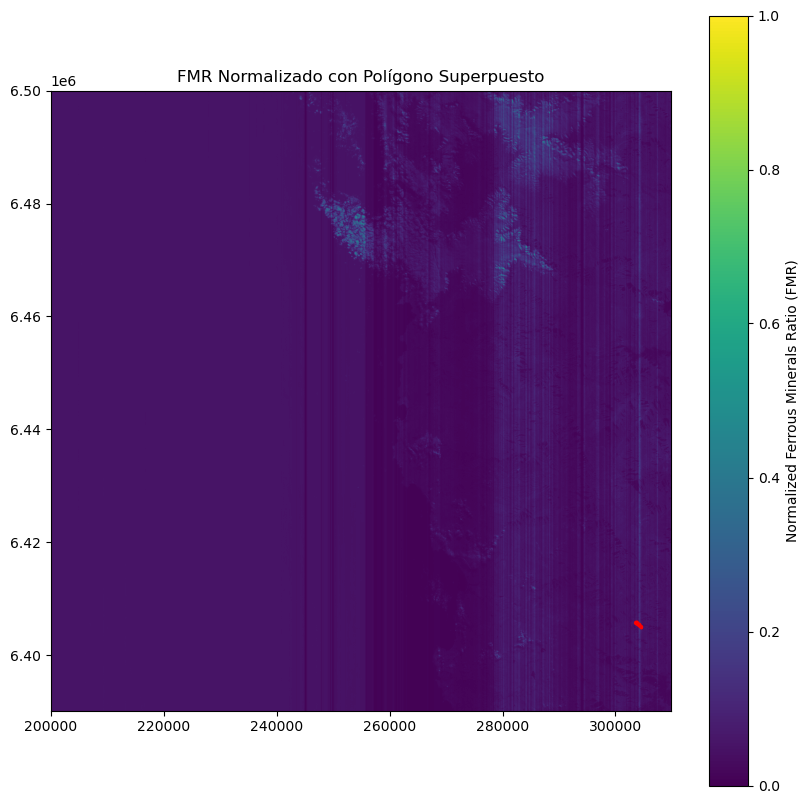

In [16]:
# Obtener las coordenadas de los límites del raster
with rasterio.open(nir_path) as src:
    bounds = src.bounds

# Visualizar FMR normalizado con el polígono superpuesto
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar FMR normalizado
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
ax.imshow(fmr_normalized, cmap='viridis', extent=extent)

# Añadir el polígono
poligono.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

# Añadir etiquetas y título
plt.colorbar(ax.imshow(fmr_normalized, cmap='viridis', extent=extent), ax=ax, label='Normalized Ferrous Minerals Ratio (FMR)')
ax.set_title('FMR Normalizado con Polígono Superpuesto')
plt.show()


Paso 1: Importar las bibliotecas necesarias

In [17]:
import rasterio
from rasterio.enums import Resampling
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


Paso 2: Definir las rutas de los archivos y funciones de remuestreo

In [18]:
# Paths a los archivos JP2 de las bandas SWIR y NIR

def remuestrear_imagen(path, escala):
    with rasterio.open(path) as src:
        # Calcular nuevas dimensiones
        nueva_altura = int(src.height * escala)
        nueva_anchura = int(src.width * escala)
        
        # Remuestreo
        data = src.read(
            out_shape=(src.count, nueva_altura, nueva_anchura),
            resampling=Resampling.bilinear
        )
        
        # Calcular nueva transformación
        nueva_transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]),
            (src.height / data.shape[-2])
        )
        
        return data, nueva_transform


Paso 3: Leer y remuestrear las bandas NIR y SWIR

In [19]:
# Remuestrear NIR de 10m a 20m para que coincida con SWIR
nir_data, nir_transform = remuestrear_imagen(nir_path, 0.5)

# Leer SWIR sin remuestrear (ya está a 20m)
with rasterio.open(swir_path) as src:
    swir_data = src.read(1)  # Lee la primera banda del archivo (y única en este caso)


Paso 4: Calcular el FMR y normalizarlo

In [20]:
# Convertir datos a float para evitar problemas con la división de enteros
nir_data = nir_data[0].astype('float32')  # Asegurarse de que sea 2D
swir_data = swir_data.astype('float32')

# Evitar divisiones por cero
nir_data[nir_data == 0] = np.nan

# Calcular FMR
fmr = swir_data / nir_data

# Manejar valores NaN o infinitos resultantes de la división por cero o por datos no válidos
fmr = np.nan_to_num(fmr, nan=0.0, posinf=0.0, neginf=0.0)

# Normalizar FMR usando Min-Max Scaling
fmr_min = np.min(fmr)
fmr_max = np.max(fmr)
fmr_normalized = (fmr - fmr_min) / (fmr_max - fmr_min)


Paso 5: Cargar el polígono y recortar el FMR normalizado

In [21]:
# Cargar el archivo GeoJSON que contiene el polígono
poligono = gpd.read_file('minera_lascenizas.geojson')

# Verificar y transformar el CRS del polígono para que coincida con el raster
with rasterio.open(nir_path) as src:
    raster_crs = src.crs

# Transformar el CRS del polígono si es necesario
if poligono.crs != raster_crs:
    poligono = poligono.to_crs(raster_crs)

# Guardar FMR normalizado como un archivo temporal para poder recortarlo
fmr_temp_path = 'fmr_temp.tif'
with rasterio.open(fmr_temp_path, 'w', driver='GTiff', height=fmr_normalized.shape[0],
                   width=fmr_normalized.shape[1], count=1, dtype=fmr_normalized.dtype, transform=nir_transform) as dst:
    dst.write(fmr_normalized, 1)

# Recortar FMR con el polígono
fmr_recortada, fmr_meta = mask(rasterio.open(fmr_temp_path), poligono.geometry, crop=True)


Paso 6: Visualizar el resultado recortado

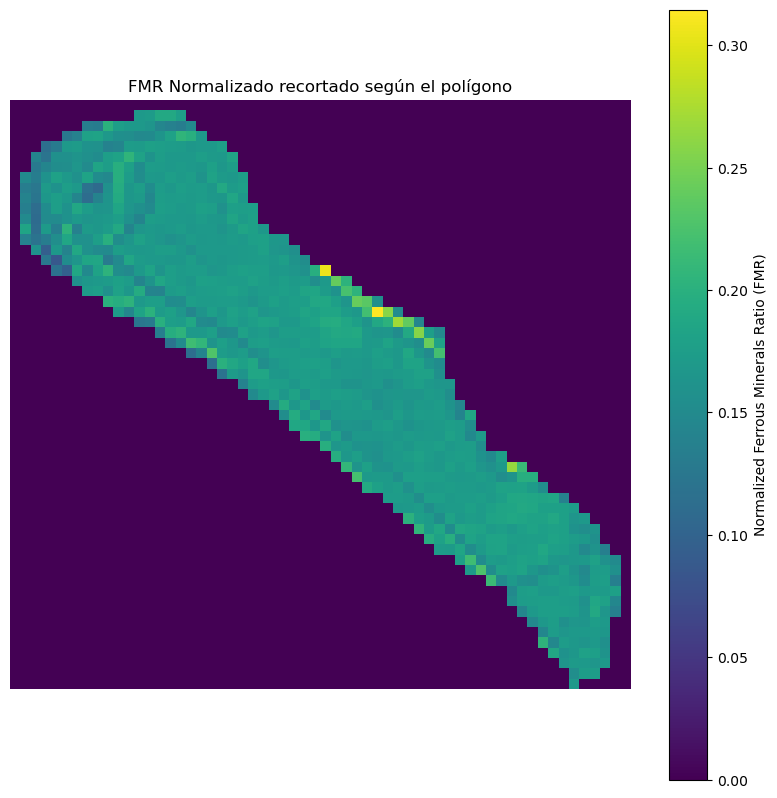

In [22]:
# Visualizar FMR recortado
plt.figure(figsize=(10, 10))
plt.imshow(np.squeeze(fmr_recortada), cmap='viridis')
plt.colorbar(label='Normalized Ferrous Minerals Ratio (FMR)')
plt.title('FMR Normalizado recortado según el polígono')
plt.axis('off')  # Omitir los ejes para una vista limpia
plt.show()
